## 1 state 1 action transitive data

In [1]:
import numpy as np
from utils.collect_data import collect_preference_intransitive_data, check_cyclic_order, check_data_consistency
import torch
from typing import List
import numpy as np
import torch.cuda
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import copy
import nashpy as nash
import optuna

from utils.logger import Logger
from utils.io_utils import save_code
from utils.utils import model_comparison,distribution_comparison, generate_outputs_from_distribution
from utils.plot import two_action_prob_plot

from algorithm_single_state import RewardModel, MaximumLikelihoodEstimator,PolicyGradientOptimizer,DirectPreferenceOptimizer, SelfPlayPreferenceOptimizer, SPPOClosedForm
from policy import UniformPolicyModel,PolicyModel,Ref_PolicyModel
from utils.collect_data import collect_preference_data, NonMonotonicScalarToVectorNN, check_data_consistency, check_cyclic_order
from datetime import datetime

/opt/common/envs/bandit/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
actions = [-10,0,10]
state_dim = 1
torch.manual_seed(5)
np.random.seed(5)

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
log_dir = f"./logs/test_{current_time}"
save_code(log_dir)

logger = Logger(log_dir)
writer = SummaryWriter(log_dir)

## Collect data

In [3]:
p_list_trans =np.array([
    [0.5, 0.9, 0.8],
    [0.1, 0.5, 0.8],
    [0.2, 0.1, 0.5]  
])

In [4]:
pref_dataset_trans = collect_preference_intransitive_data(p_list_trans, actions,60)
pref_dataset_trans

[Transition(state=array([0]), action_0=-10, action_1=0, pref=0, chosen_probs=0.9),
 Transition(state=array([0]), action_0=0, action_1=-10, pref=1, chosen_probs=0.9),
 Transition(state=array([0]), action_0=10, action_1=0, pref=1, chosen_probs=0.8),
 Transition(state=array([0]), action_0=0, action_1=10, pref=0, chosen_probs=0.8),
 Transition(state=array([0]), action_0=10, action_1=0, pref=1, chosen_probs=0.8),
 Transition(state=array([0]), action_0=10, action_1=0, pref=1, chosen_probs=0.8),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=0, chosen_probs=0.8),
 Transition(state=array([0]), action_0=-10, action_1=0, pref=0, chosen_probs=0.9),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=0, chosen_probs=0.8),
 Transition(state=array([0]), action_0=10, action_1=-10, pref=1, chosen_probs=0.8),
 Transition(state=array([0]), action_0=0, action_1=10, pref=0, chosen_probs=0.8),
 Transition(state=array([0]), action_0=0, action_1=10, pref=0, chosen_probs=0.8),
 Transi

In [5]:
action_to_index = {-10: 0, 0: 1, 10: 2}

states_trans = torch.tensor([x.state[0] for x in pref_dataset_trans], dtype=torch.float32).to(device).unsqueeze(1)

positive_actions_trans = torch.cat(
    [torch.tensor(action_to_index[x.action_1] if x.pref == 1 else action_to_index[x.action_0]).unsqueeze(0) for x in pref_dataset_trans],
    dim=0
).to(device)

negative_actions_trans = torch.cat(
    [torch.tensor(action_to_index[x.action_0] if x.pref == 1 else action_to_index[x.action_1]).unsqueeze(0) for x in pref_dataset_trans],
    dim=0
).to(device)

print(f"states: {states_trans.shape}")
print(f"positive_actions: {positive_actions_trans}")
print(f"negative_actions: {negative_actions_trans}")

# check transition and consistency
print(f"check transition: {check_cyclic_order(p_list_trans,actions)}")
print(f"check data consistency: {check_data_consistency(pref_dataset_trans)}")

states: torch.Size([60, 1])
positive_actions: tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 1,
        2, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
negative_actions: tensor([1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 2,
        1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2,
        1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 1], device='cuda:0')
check transition: (False, None)
check data consistency: 0.9333333333333333


In [6]:
# compute nash equilibrium

game = nash.Game(p_list_trans, -p_list_trans)

#game = nash.Game(A, -A)
equilibria = list(game.support_enumeration())

for eq in equilibria:
    print("Nash equilibrium of this game: ", eq[0])  

Nash equilibrium of this game:  [1. 0. 0.]


In [7]:
nash_point_trans= [eq[0][0],eq[0][1]]
nash_point_trans

[1.0, 0.0]

In [8]:
ref_policy = UniformPolicyModel(
    action_num=len(actions),
    device=device
).to(device)

ref_policy2 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.7,0.2,0.1]]),device).to(device)

ref_policy3 = Ref_PolicyModel(
    len(actions),torch.tensor([[1.0,0.0,0.0]]),device).to(device)

ref_policy4 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.1,0.3,0.6]]),device).to(device)

print(ref_policy(torch.tensor([[0.0]])))
print(ref_policy2(torch.tensor([[0.0]])))
print(ref_policy3(torch.tensor([[0.0]])))
print(ref_policy4(torch.tensor([[0.0]])))

tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([[0.7000, 0.2000, 0.1000]], device='cuda:0')
tensor([[1., 0., 0.]], device='cuda:0')
tensor([[0.1000, 0.3000, 0.6000]], device='cuda:0')


## DPO

In [9]:
policy_dpo_1_trans = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_2_trans = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_3_trans = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_4_trans = PolicyModel(   
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [10]:
dpo_optimizer_1_trans = DirectPreferenceOptimizer(
    policy=policy_dpo_1_trans,
    ref_policy=ref_policy,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point_trans
)

dpo_optimizer_2_trans = DirectPreferenceOptimizer(
    policy=policy_dpo_2_trans,
    ref_policy=ref_policy2,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point_trans
)

dpo_optimizer_3_trans = DirectPreferenceOptimizer(
    policy=policy_dpo_3_trans,
    ref_policy=ref_policy3,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point_trans
)

dpo_optimizer_4_trans = DirectPreferenceOptimizer(
    policy=policy_dpo_4_trans,
    ref_policy=ref_policy4,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point_trans
)

/home/hanwen/policy_optimization/exp/utils/utils.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
2024-12-07 17:37:09,365 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 0 loss: 0.6650 grad norm: 0.7181 policy: 0.3311 0.3813
2024-12-07 17:37:13,007 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 5 loss: 0.6157 grad norm: 0.6452 policy: 0.3675 0.3700
2024-12-07 17:37:16,399 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 10 loss: 0.5719 grad norm: 0.6340 policy: 0.4036 0.3595
2024-12-07 17:37:19,813 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 15 loss: 0.5312

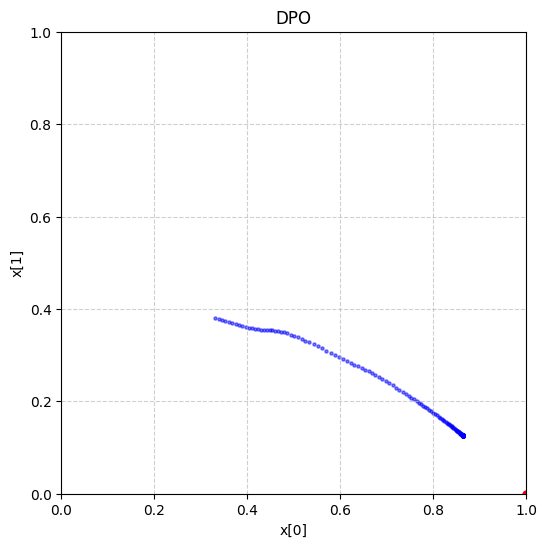

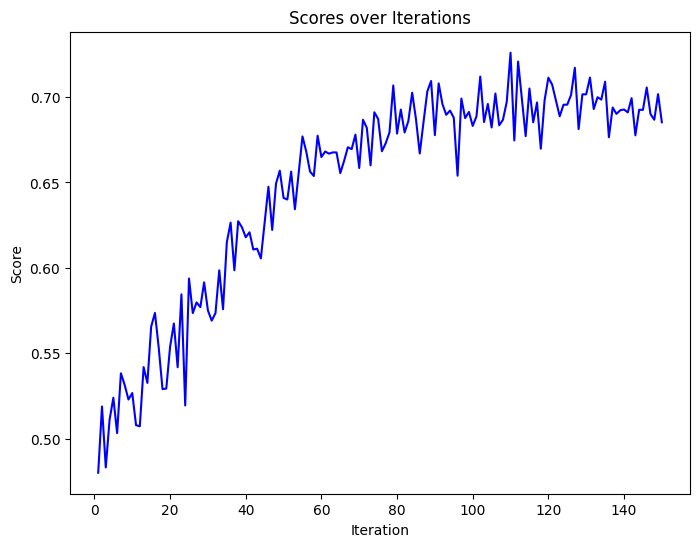

2024-12-07 17:38:56,781 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 0 loss: 1.5195 grad norm: 1.3933 policy: 0.2940 0.3360
2024-12-07 17:39:00,370 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 5 loss: 1.3935 grad norm: 1.2656 policy: 0.3443 0.3272
2024-12-07 17:39:03,899 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 10 loss: 1.2792 grad norm: 1.2051 policy: 0.3926 0.3191
2024-12-07 17:39:07,661 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 15 loss: 1.1744 grad norm: 1.2122 policy: 0.4401 0.3098
2024-12-07 17:39:11,274 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 20 loss: 1.0705 grad norm: 1.2448 policy: 0.4866 0.3015
2024-12-07 17:39:14,843 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: 

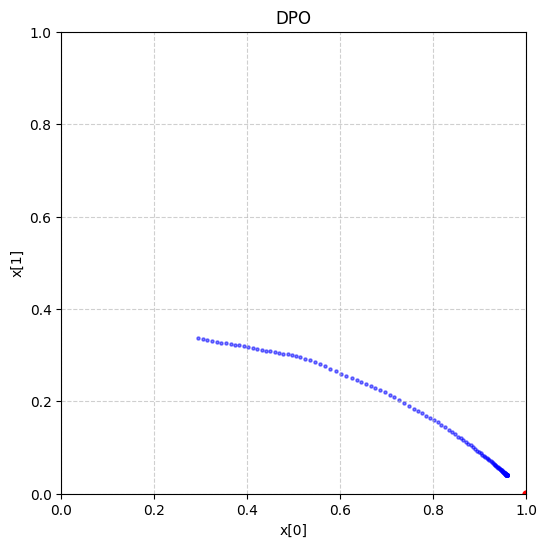

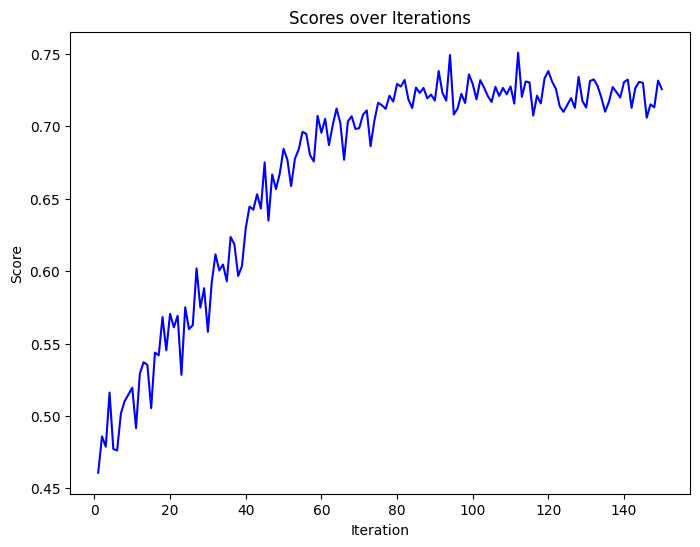

2024-12-07 17:40:45,744 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 0 loss: 12.9519 grad norm: 1.3997 policy: 0.3366 0.3431
2024-12-07 17:40:49,378 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 5 loss: 12.8228 grad norm: 1.3824 policy: 0.3887 0.3185
2024-12-07 17:40:52,748 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 10 loss: 12.7079 grad norm: 1.4109 policy: 0.4382 0.2945
2024-12-07 17:40:56,284 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 15 loss: 12.5908 grad norm: 1.5282 policy: 0.4904 0.2698
2024-12-07 17:40:59,998 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 20 loss: 12.4627 grad norm: 1.6894 policy: 0.5480 0.2429
2024-12-07 17:41:03,391 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - I

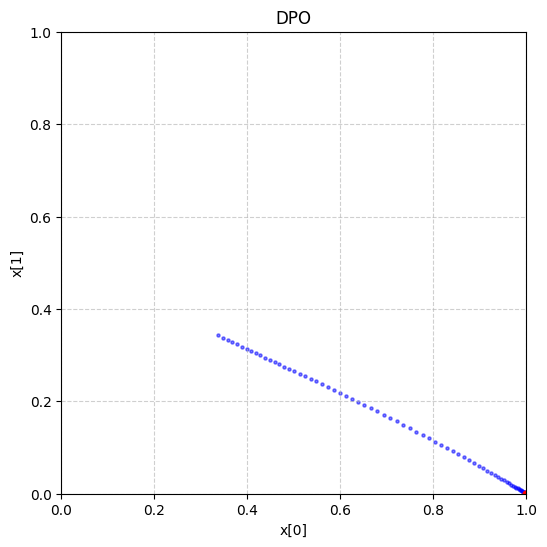

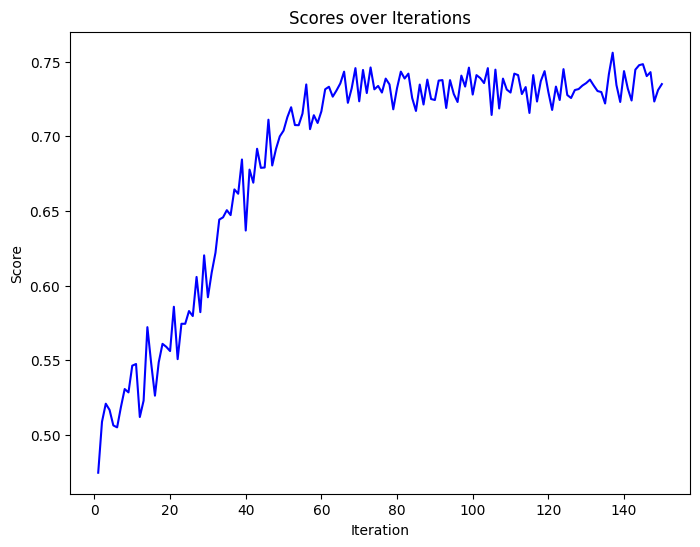

2024-12-07 17:41:41,448 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 0 loss: 0.3463 grad norm: 0.2537 policy: 0.3630 0.3789
2024-12-07 17:41:42,850 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 5 loss: 0.3252 grad norm: 0.2174 policy: 0.3961 0.3858
2024-12-07 17:41:43,787 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 10 loss: 0.3082 grad norm: 0.1922 policy: 0.4282 0.3900
2024-12-07 17:41:47,034 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 15 loss: 0.2939 grad norm: 0.1681 policy: 0.4619 0.3900
2024-12-07 17:41:47,773 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 20 loss: 0.2825 grad norm: 0.1406 policy: 0.4983 0.3831
2024-12-07 17:41:49,105 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: 

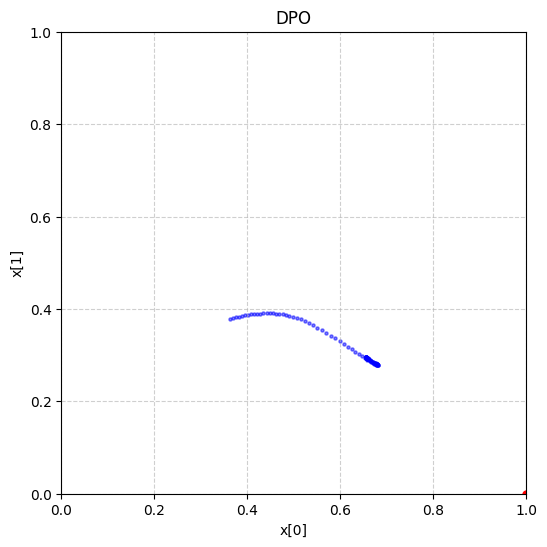

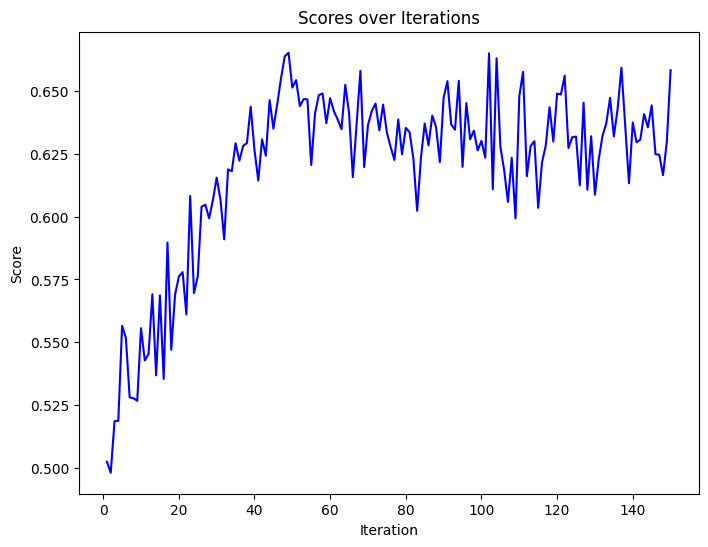

In [11]:
dpo_optimizer_1_trans.optimize(
    states=states_trans,
    positive_actions=positive_actions_trans,
    negative_actions=negative_actions_trans,
    p_list=p_list_trans,
    num_epochs=150
) # ref_policy = [0.33,0.33,0.33]

dpo_optimizer_2_trans.optimize(
    states=states_trans,
    positive_actions=positive_actions_trans,
    negative_actions=negative_actions_trans,
    p_list=p_list_trans,
    num_epochs=150
) # ref_policy = [0.7,0.2,0.1]

dpo_optimizer_3_trans.optimize(
    states=states_trans,
    positive_actions=positive_actions_trans,
    negative_actions=negative_actions_trans,
    p_list=p_list_trans,
    num_epochs=150
) # ref_policy = [1.0,0.0,0.0]

dpo_optimizer_4_trans.optimize(
    states=states_trans,
    positive_actions=positive_actions_trans,
    negative_actions=negative_actions_trans,
    p_list=p_list_trans,
    num_epochs=150
) # ref_policy = [0.1,0.3,0.6]

In [12]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs_trans = policy_dpo_1_trans(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs_trans[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
# compare the learned policy with the reference policy
score_trans = model_comparison(policy_dpo_1_trans, ref_policy,p_list_trans)
print(f"\nDPO model and base model comparison score: {score_trans:.3f}")

with torch.no_grad():
    action_probs_trans = policy_dpo_2_trans(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs_trans[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2_trans = model_comparison(policy_dpo_2_trans, ref_policy,p_list_trans)
print(f"\nDPO model and base model comparison score: {score2_trans:.3f}")

with torch.no_grad():
    action_probs_trans = policy_dpo_3_trans(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs_trans[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3_trans = model_comparison(policy_dpo_3_trans, ref_policy,p_list_trans)
print(f"\nDPO model and base model comparison score: {score3_trans:.3f}")

with torch.no_grad():
    action_probs_trans = policy_dpo_4_trans(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs_trans[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4_trans = model_comparison(policy_dpo_4_trans, ref_policy,p_list_trans)
print(f"\nDPO model and base model comparison score: {score4_trans:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.863
P(action=0) = 0.127
P(action=10) = 0.010

DPO model and base model comparison score: 0.688

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.958
P(action=0) = 0.040
P(action=10) = 0.002

DPO model and base model comparison score: 0.730

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 1.000
P(action=0) = 0.000
P(action=10) = 0.000

DPO model and base model comparison score: 0.732

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.659
P(action=0) = 0.292
P(action=10) = 0.048

DPO model and base model comparison score: 0.613


## RLHF

In [21]:
learned_reward_model_trans = RewardModel(
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
)

In [22]:
mle_learner_trans = MaximumLikelihoodEstimator(
    actions,
    learned_reward_model_trans,
    learning_rate=1e-4,
    batch_size=64,
    logger=logger,
)

In [23]:
mle_learner_trans.optimize(
    states_trans, positive_actions_trans, negative_actions_trans, num_epochs=20
)

2024-12-07 18:20:41,009 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 0 loss: 0.6647 acc: 0.93
2024-12-07 18:20:41,016 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 2 loss: 0.6594 acc: 0.93
2024-12-07 18:20:41,021 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 4 loss: 0.6542 acc: 0.93
2024-12-07 18:20:41,027 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 6 loss: 0.6490 acc: 0.93
2024-12-07 18:20:41,033 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 8 loss: 0.6439 acc: 0.93
2024-12-07 18:20:41,039 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 10 loss: 0.6389 acc: 0.93
2024-12-07 18:20:41,045 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] E

In [27]:
# pg
policy_pg_1_trans = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_pg_2_trans = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_pg_3_trans = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_pg_4_trans = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [28]:
pg_optimizer_1_trans = PolicyGradientOptimizer(
    policy=policy_pg_1_trans,
    reward_model=learned_reward_model_trans,
    ref_policy=ref_policy,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point_trans
)

pg_optimizer_2_trans = PolicyGradientOptimizer(
    policy=policy_pg_2_trans,
    reward_model=learned_reward_model_trans,
    ref_policy=ref_policy2,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point_trans
)

pg_optimizer_3_trans = PolicyGradientOptimizer(
    policy=policy_pg_3_trans,
    reward_model=learned_reward_model_trans,
    ref_policy=ref_policy3,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point_trans
)

pg_optimizer_4_trans = PolicyGradientOptimizer(
    policy=policy_pg_4_trans,
    reward_model=learned_reward_model_trans,
    ref_policy=ref_policy4,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point_trans
)

2024-12-07 18:37:55,527 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 0 loss: 0.0466 reward: -0.0466 ref_reward: -0.0284 improvement: -63.97%
2024-12-07 18:37:57,215 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 2 loss: 0.0369 reward: -0.0369 ref_reward: -0.0284 improvement: -29.99%
2024-12-07 18:37:58,812 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 4 loss: 0.0296 reward: -0.0296 ref_reward: -0.0284 improvement: -4.33%
2024-12-07 18:38:00,269 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 6 loss: 0.0246 reward: -0.0246 ref_reward: -0.0284 improvement: 13.50%
2024-12-07 18:38:01,647 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 8 loss: 0.0213 reward: -0.0213 ref_reward: -0.0284 improvement: 24.95%
2024-12-07 18:38:03,171 - /home/h

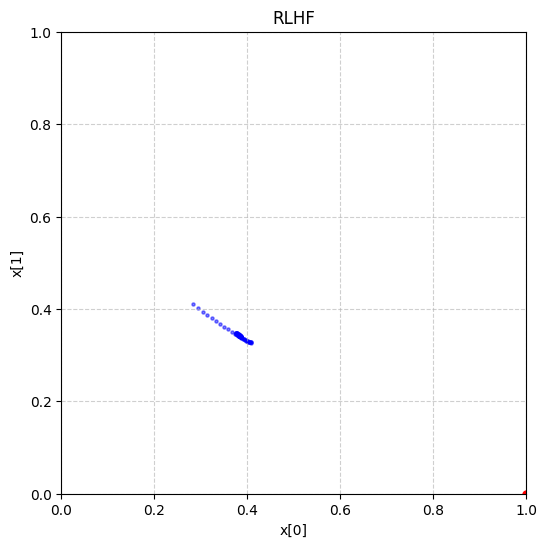

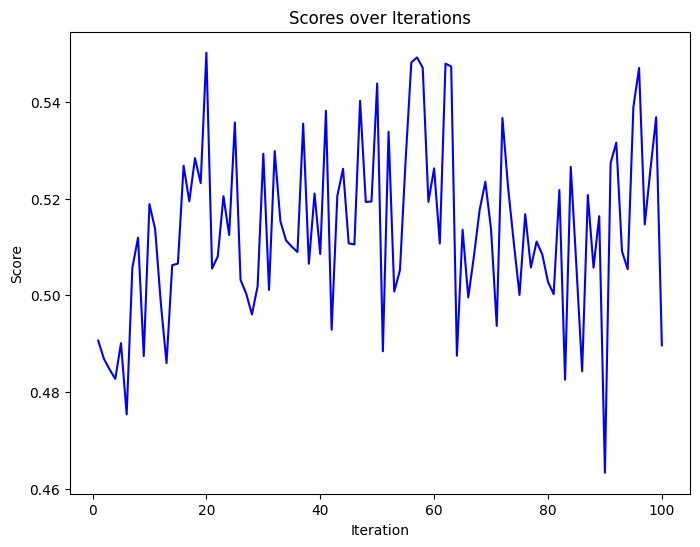

2024-12-07 18:39:07,728 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 0 loss: 0.2938 reward: -0.2938 ref_reward: 0.0634 improvement: -563.26%
2024-12-07 18:39:09,246 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 2 loss: 0.2524 reward: -0.2524 ref_reward: 0.0634 improvement: -497.89%
2024-12-07 18:39:10,663 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 4 loss: 0.2137 reward: -0.2137 ref_reward: 0.0634 improvement: -436.94%
2024-12-07 18:39:12,104 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 6 loss: 0.1778 reward: -0.1778 ref_reward: 0.0634 improvement: -380.26%
2024-12-07 18:39:13,522 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 8 loss: 0.1433 reward: -0.1433 ref_reward: 0.0634 improvement: -326.00%
2024-12-07 18:39:14,933 - /hom

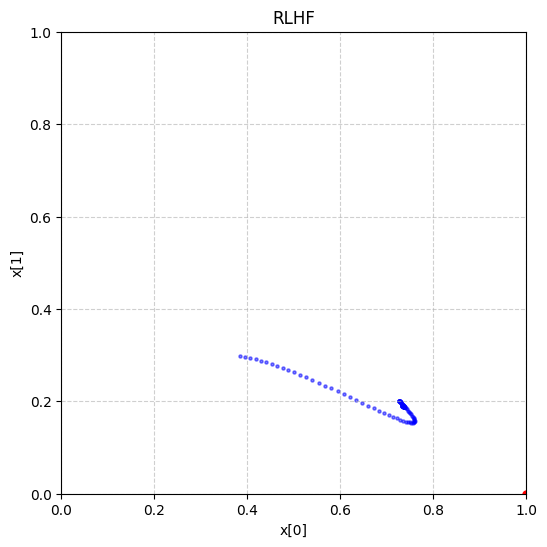

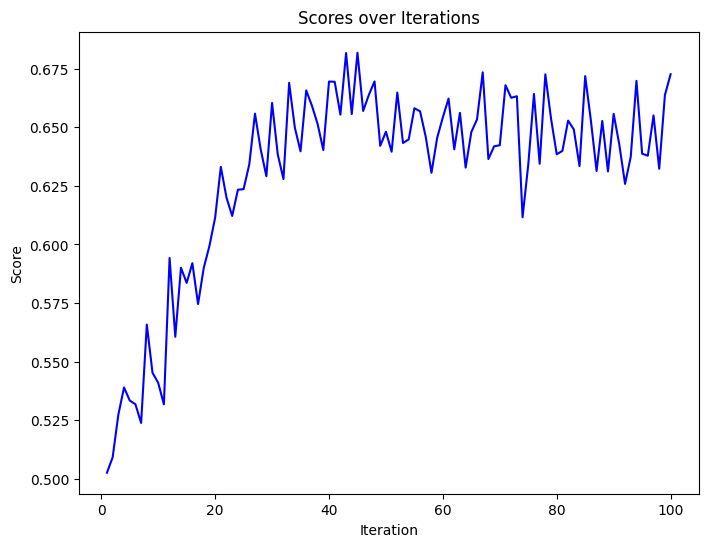

2024-12-07 18:40:21,069 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 0 loss: 13.6866 reward: -13.6866 ref_reward: 0.1106 improvement: -12479.16%
2024-12-07 18:40:22,436 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 2 loss: 12.9910 reward: -12.9910 ref_reward: 0.1106 improvement: -11849.95%
2024-12-07 18:40:23,942 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 4 loss: 12.2873 reward: -12.2873 ref_reward: 0.1106 improvement: -11213.52%
2024-12-07 18:40:25,417 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 6 loss: 11.5879 reward: -11.5879 ref_reward: 0.1106 improvement: -10580.89%
2024-12-07 18:40:26,884 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 8 loss: 10.9234 reward: -10.9234 ref_reward: 0.1106 improvement: -9979.89%
2024-12-07 

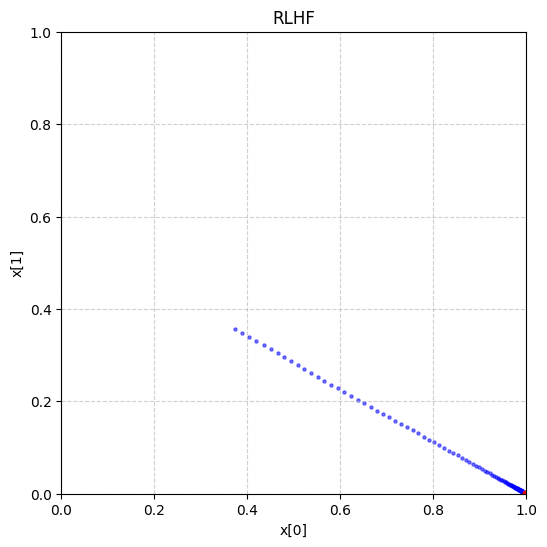

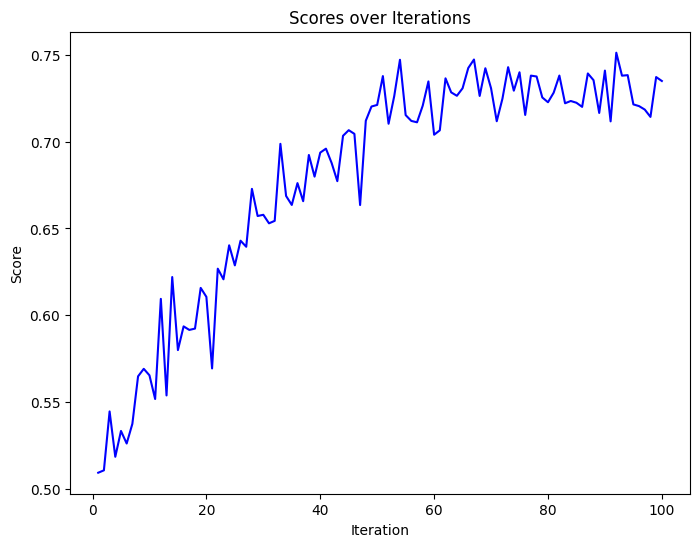

2024-12-07 18:41:33,627 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 0 loss: 0.1689 reward: -0.1689 ref_reward: -0.1118 improvement: -51.05%
2024-12-07 18:41:34,977 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 2 loss: 0.1534 reward: -0.1534 ref_reward: -0.1118 improvement: -37.18%
2024-12-07 18:41:36,508 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 4 loss: 0.1407 reward: -0.1407 ref_reward: -0.1118 improvement: -25.88%
2024-12-07 18:41:37,968 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 6 loss: 0.1311 reward: -0.1311 ref_reward: -0.1118 improvement: -17.22%
2024-12-07 18:41:39,357 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 8 loss: 0.1239 reward: -0.1239 ref_reward: -0.1118 improvement: -10.81%
2024-12-07 18:41:40,868 - /hom

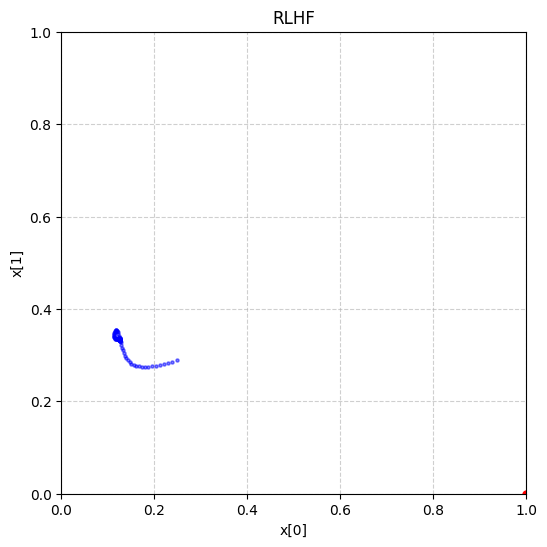

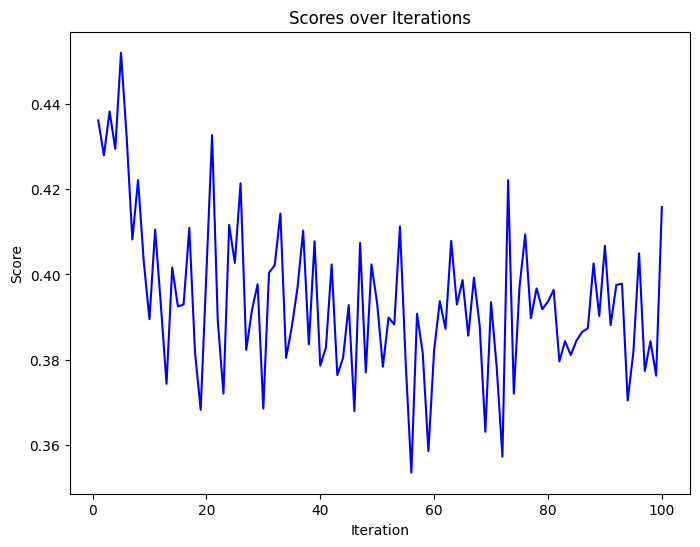

In [29]:
pg_optimizer_1_trans.optimize(states=states_trans, p_list=p_list_trans, num_epochs=100) # ref_policy = uniform
pg_optimizer_2_trans.optimize(states=states_trans, p_list=p_list_trans, num_epochs=100) # ref_policy = [0.7,0.2,0.1]
pg_optimizer_3_trans.optimize(states=states_trans, p_list=p_list_trans, num_epochs=100) # ref_policy = [1.0,0.0,0.0]
pg_optimizer_4_trans.optimize(states=states_trans, p_list=p_list_trans, num_epochs=100) # ref_policy = [0.1,0.3,0.6]


In [30]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs_trans = policy_pg_1_trans(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs_trans[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
# compare the learned policy with the reference policy
score_trans = model_comparison(policy_pg_1_trans, ref_policy,p_list_trans)
print(f"\nRLHF model and base model comparison score: {score_trans:.3f}")

with torch.no_grad():
    action_probs_trans = policy_pg_2_trans(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs_trans[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2_trans = model_comparison(policy_pg_2_trans, ref_policy,p_list_trans)
print(f"\nRLHF model and base model comparison score: {score2_trans:.3f}")

with torch.no_grad():
    action_probs_trans = policy_pg_3_trans(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs_trans[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3_trans = model_comparison(policy_pg_3_trans, ref_policy,p_list_trans)
print(f"\nRLHF model and base model comparison score: {score3_trans:.3f}")

with torch.no_grad():
    action_probs_trans = policy_pg_4_trans(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs_trans[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4_trans = model_comparison(policy_pg_4_trans, ref_policy,p_list_trans)
print(f"\nRLHF model and base model comparison score: {score4_trans:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.384
P(action=0) = 0.342
P(action=10) = 0.274


/home/hanwen/policy_optimization/exp/utils/utils.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)



RLHF model and base model comparison score: 0.530

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.732
P(action=0) = 0.191
P(action=10) = 0.077

RLHF model and base model comparison score: 0.665

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 0.991
P(action=0) = 0.005
P(action=10) = 0.004

RLHF model and base model comparison score: 0.725

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.124
P(action=0) = 0.335
P(action=10) = 0.541

RLHF model and base model comparison score: 0.382


## SPPO

## SPPO Close Form

In [13]:
sppo_closed_form_1_trans = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point_trans
)

sppo_closed_form_2_trans = SPPOClosedForm( 
    actions,                      
    score_ref_model = ref_policy,             
    ref_policy=ref_policy2,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point_trans
)

sppo_closed_form_3_trans = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy3,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point_trans
)

sppo_closed_form_4_trans = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy4,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point_trans
)

2024-12-07 17:50:41,589 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 0: ref_distribution = tensor([0.3333, 0.3333, 0.3333], device='cuda:0'), new_distribution = tensor([0.3341, 0.3333, 0.3326], device='cuda:0')
2024-12-07 17:50:41,948 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 1: ref_distribution = tensor([0.3341, 0.3333, 0.3326], device='cuda:0'), new_distribution = tensor([0.3350, 0.3332, 0.3319], device='cuda:0')
2024-12-07 17:50:42,350 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 2: ref_distribution = tensor([0.3350, 0.3332, 0.3319], device='cuda:0'), new_distribution = tensor([0.3358, 0.3331, 0.3311], device='cuda:0')
2024-12-07 17:50:42,826 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 3: ref_distribution = tensor([0.3358, 0.3331, 0.3311], device='cuda:0'), new_distribution = tensor([0.3366

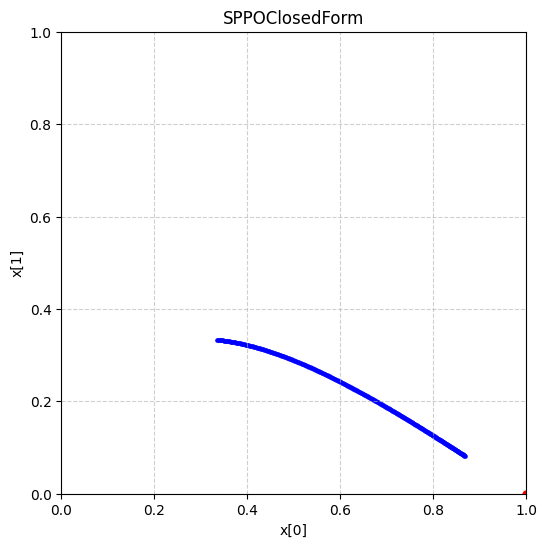

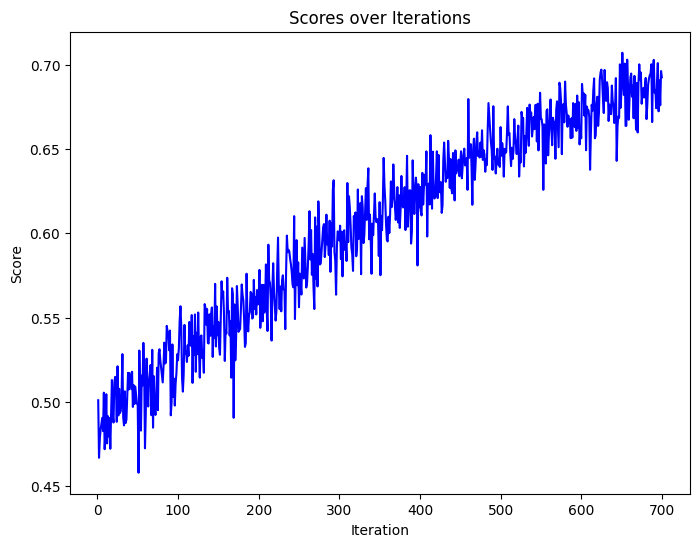

2024-12-07 17:55:10,553 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 0: ref_distribution = tensor([0.7000, 0.2000, 0.1000], device='cuda:0'), new_distribution = tensor([0.7008, 0.1995, 0.0997], device='cuda:0')
2024-12-07 17:55:10,809 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 1: ref_distribution = tensor([0.7008, 0.1995, 0.0997], device='cuda:0'), new_distribution = tensor([0.7016, 0.1990, 0.0994], device='cuda:0')
2024-12-07 17:55:11,277 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 2: ref_distribution = tensor([0.7016, 0.1990, 0.0994], device='cuda:0'), new_distribution = tensor([0.7023, 0.1985, 0.0991], device='cuda:0')
2024-12-07 17:55:11,611 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 3: ref_distribution = tensor([0.7023, 0.1985, 0.0991], device='cuda:0'), new_distribution = tensor([0.7031

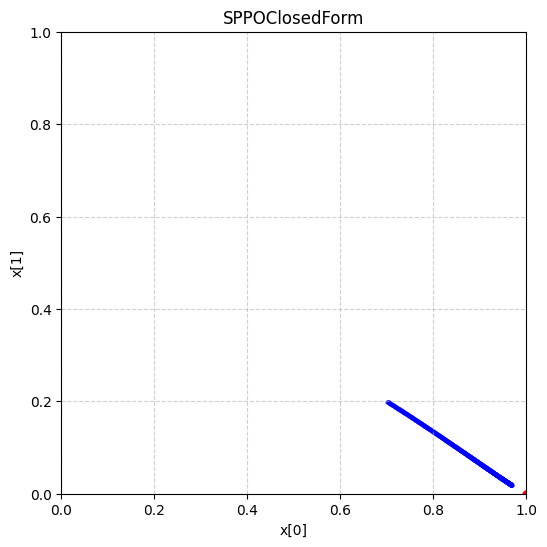

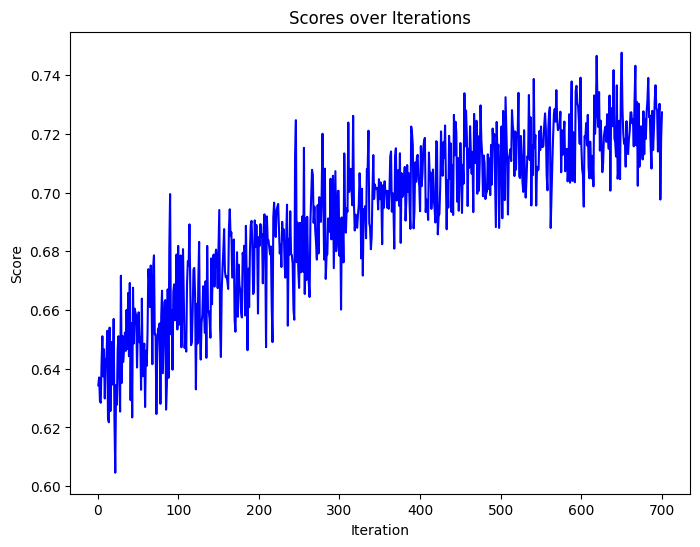

2024-12-07 17:58:30,025 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 0: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-12-07 17:58:30,501 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 1: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-12-07 17:58:30,768 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 2: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-12-07 17:58:31,151 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 3: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-12-07 17:58:31,619 - /home/hanwen/policy_optimization/e

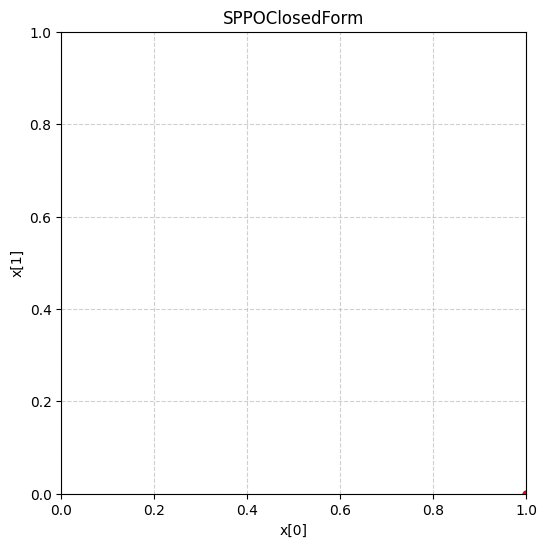

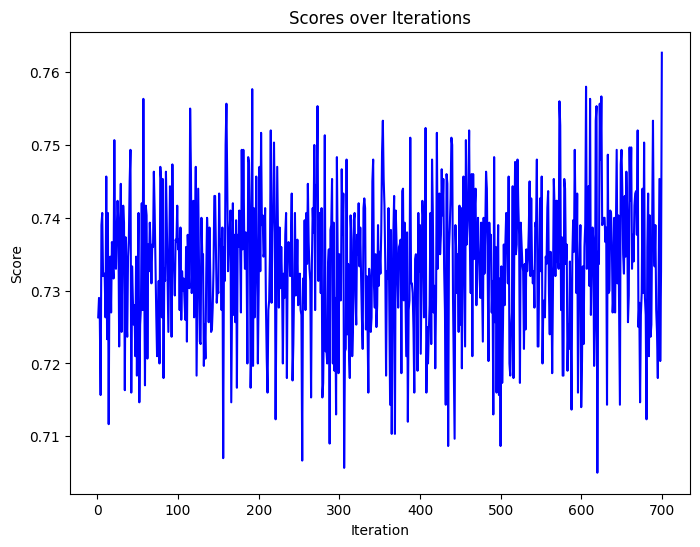

2024-12-07 18:02:58,017 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 0: ref_distribution = tensor([0.1000, 0.3000, 0.6000], device='cuda:0'), new_distribution = tensor([0.1003, 0.3005, 0.5992], device='cuda:0')
2024-12-07 18:02:58,402 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 1: ref_distribution = tensor([0.1003, 0.3005, 0.5992], device='cuda:0'), new_distribution = tensor([0.1006, 0.3009, 0.5984], device='cuda:0')
2024-12-07 18:02:58,679 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 2: ref_distribution = tensor([0.1006, 0.3009, 0.5984], device='cuda:0'), new_distribution = tensor([0.1010, 0.3014, 0.5976], device='cuda:0')
2024-12-07 18:02:59,163 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 3: ref_distribution = tensor([0.1010, 0.3014, 0.5976], device='cuda:0'), new_distribution = tensor([0.1013

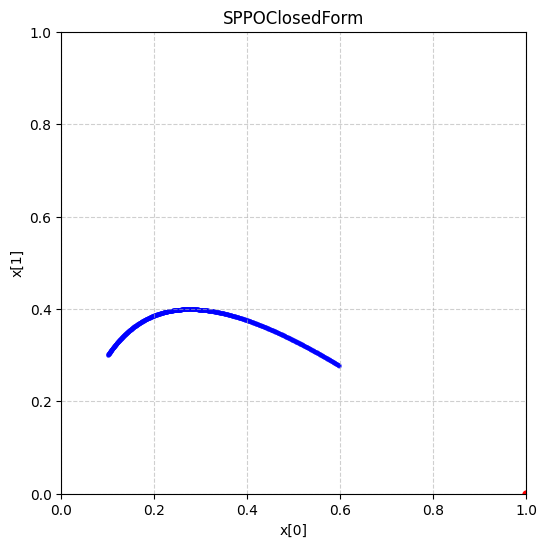

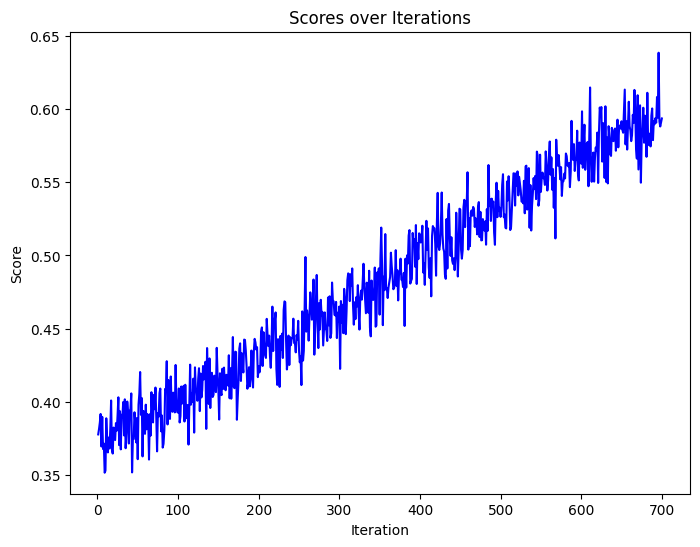

In [14]:
sppo_distribution_1_trans = sppo_closed_form_1_trans.optimize(
    p_list=p_list_trans,
    num_iters=700
)   

sppo_distribution2_trans = sppo_closed_form_2_trans.optimize(
    p_list=p_list_trans,
    num_iters=700
)

sppo_distribution3_trans = sppo_closed_form_3_trans.optimize(
    p_list=p_list_trans,
    num_iters=700
)

sppo_distribution4_trans = sppo_closed_form_4_trans.optimize(
    p_list=p_list_trans,
    num_iters=700
)

In [15]:
print("\n ##### Learned policy probabilities of SPPO-ClosedForm: #####")
with torch.no_grad():
    action_probs_sppo1_trans = sppo_distribution_1_trans
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_sppo1_trans.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo1_trans = distribution_comparison(sppo_distribution_1_trans, ref_policy,p_list_trans)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo1_trans:.3f}")
    
    
    action_probs_sppo2_trans = sppo_distribution2_trans
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_sppo2_trans.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo2_trans = distribution_comparison(sppo_distribution2_trans, ref_policy,p_list_trans)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo2_trans:.3f}")
    
    
    action_probs_sppo3_trans = sppo_distribution3_trans
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_sppo3_trans.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo3_trans = distribution_comparison(sppo_distribution3_trans, ref_policy,p_list_trans)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo3_trans:.3f}")
    
    
    action_probs_sppo4_trans = sppo_distribution4_trans
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_sppo4_trans.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo4_trans = distribution_comparison(sppo_distribution4_trans, ref_policy,p_list_trans)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo4_trans:.3f}")


 ##### Learned policy probabilities of SPPO-ClosedForm: #####

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.868
P(action=0) = 0.082
P(action=10) = 0.050

SPPO-ClosedForm model and base model comparison score: 0.689

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:
P(action=-10) = 0.968
P(action=0) = 0.019
P(action=10) = 0.013

SPPO-ClosedForm model and base model comparison score: 0.712

Learned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:
P(action=-10) = 1.000
P(action=0) = 0.000
P(action=10) = 0.000

SPPO-ClosedForm model and base model comparison score: 0.743

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:
P(action=-10) = 0.598
P(action=0) = 0.277
P(action=10) = 0.125

SPPO-ClosedForm model and base model comparison score: 0.602
